![Status: Complete](https://img.shields.io/badge/status-complete-brightgreen)
![Python](https://img.shields.io/badge/python-3.10-blue)
![Coverage](https://img.shields.io/badge/coverage-90%25-green)
![License](https://img.shields.io/badge/license-MIT-green)

<a id="table-of-contents"></a>
# 📖 Dimension Reduction

[📉 Dimensionality Reduction Overview](#dimensionality-reduction)  
- [🚧 Key Challenges in High Dimensions](#key-challenges)

[🗂️ Data Setup](#data-setup)  
- [🧾 Sample Data](#sample-data)

[📊 Principal Component Analysis (PCA)](#pca)  
- [🔄 Standardizing the Features](#standardizing-the-features)  
- [📈 Scree Plot: Cumulative Explained Variance](#scree-plot)  
- [📉 Apply PCA: Reducing to n Principal Components](#apply-pca)  
- [📊 PCA Loadings: Feature Contributions](#pca-loadings)  
- [📊 Visualizing Feature Contributions to PCAs](#pca-visuals)  
- [🧭 Visualizing PCA Results in 2D](#pca-2d-scatter)  
- [📈 Variance Explained by Each Component](#variance-explained)
- [🧾 Visual Comparison: Original vs PCA-Transformed Data](#pca-before-after)

[🌌 t-SNE (t-Distributed Stochastic Neighbor Embedding)](#tsne)  
- [🔍 Intuition Behind t-SNE](#tsne-intuition)  
- [⚙️ How t-SNE Works](#how-tsne-works)
- [🎯 When Should You Use t-SNE?](#when-to-use-tsne)
- [🧪 Key Parameters and Tuning Tips](#tsne-hyperparams)  
- [📊 Visualizing t-SNE Output](#tsne-visuals)
- [🚫 Limitations and Cautions](#tsne-limitations)  

[🌐 UMAP (Uniform Manifold Approximation & Projection)](#umap)  
- [🔬 UMAP vs t-SNE](#umap-vs-tsne)  
- [⚙️ How UMAP Works](#how-umap-works)  
- [🛠️ Implementation](#umap-impl)  
- [📊 Visualizing UMAP Output](#umap-visuals)  
- [🔁 Reusing UMAP for Feature Reduction](#umap-transform-use)

[📐 Linear Discriminant Analysis (LDA)](#lda)  
- [🔢 How LDA Works](#how-lda-works)  
- [🧮 Step-by-Step Breakdown](#lda-steps)  
- [📉 Dimensionality Constraint](#lda-constraint)  
- [🛠️ Implementation](#lda-impl)  
- [📊 Visualizing LDA Output](#lda-visuals)

[🔗 Canonical Correlation Analysis (CCA)](#cca)  
- [🧬 When It’s Useful](#when-to-use-cca)  
- [🔄 Intuition: PCA for Two Views](#cca-intuition)  
- [📉 Dimensionality Reduction via Correlation](#cca-dim-reduction)  
- [🛠️ Implementation](#cca-impl)  
- [📊 Visualizing CCA Output](#cca-visuals)

[Back to the top](#table-of-contents)
___



<a id="dimensionality-reduction"></a>
# 📉 Dimensionality Reduction Overview

<details><summary><strong>📖 Click to Expand </strong></summary>
Dimensionality reduction refers to techniques that transform high-dimensional data into a lower-dimensional space — while preserving as much **useful structure or signal** as possible.

These methods are valuable across both modeling and business contexts:

- 🔄 **Simplifying data** for faster computation and easier storage  
- 📉 **Reducing overfitting** by eliminating noise or redundant features  
- 👀 **Visualizing hidden structure** in 2D or 3D  
- 📊 **Improving model interpretability** by focusing on key components

This notebook covers several popular approaches — PCA, t-SNE, UMAP, and LDA — each with distinct goals, assumptions, and business use cases.
<hr style="border: none; height: 1px; background-color: #ddd;" />
</details>

<a id="key-challenges"></a>
#### 🚧 Key Challenges in High Dimensions

<details><summary><strong>📖 Click to Expand </strong></summary>
High-dimensional datasets (e.g., 100+ features) often seem rich, but pose several practical issues:

##### ❌ Curse of Dimensionality
- Distance metrics (like Euclidean) lose meaning
- Feature space becomes sparse — hard to model effectively
- Models require exponentially more data to generalize

##### 💻 Computational Overhead
- More dimensions = higher training time
- Resource-intensive for models like clustering or k-NN

##### 👁️ Visualization Limitations
- Human intuition maxes out at 3D — we need projection techniques to reveal structure

Dimensionality reduction helps address these problems by transforming the data to **lower, information-rich representations** — enabling both insight and performance.
<hr style="border: none; height: 1px; background-color: #ddd;" />
</details>


[Back to the top](#table-of-contents)
___



<a id="data-setup"></a>
# 🗂️ Data Setup

<a id="sample-data"></a>
#### 🧾 Sample data

<details><summary><strong>📖 Click to Expand </strong></summary>

We'll simulate a retail scenario where each row represents a customer, and each column captures a behavioral signal — such as purchase frequency, monetary value, or product interaction features.

The goal is to apply dimensionality reduction techniques to:
- Identify underlying **customer personas**
- Compress features for **modeling efficiency**
- Enable **2D/3D visualization** of customer segments or churn patterns
</details>


In [4]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.datasets import load_digits, load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
# Load iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')

# Optionally attach for LDA later
df = X.copy()
df['segment'] = y.replace({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})

# Preview
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),segment
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


[Back to the top](#table-of-contents)
___


<a id="pca"></a>
# 📊 Principal Component Analysis (PCA)


<a id="standardizing-the-features"></a>
#### 🔄 Standardizing the Features

<details><summary>📖 Click to Expand </summary>

Before applying PCA, it's important to **standardize** the dataset.

PCA is sensitive to the **scale** of features — variables with larger numeric ranges (e.g., `monetary`) would otherwise dominate the components just because of their magnitude.

We use `StandardScaler` to transform all features to have:
- **Mean = 0**
- **Standard Deviation = 1**

This ensures that each feature contributes equally when computing variance and covariance.

We exclude the `segment` label from this transformation since it's categorical and not part of the PCA input space.

</details>

In [7]:
# Automatically select only numeric columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=[np.number]))
scaled_data[0:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

<a id="scree-plot"></a>
#### 📈 Scree Plot: Cumulative Explained Variance

<details><summary>📖 Click to Expand </summary>

Once PCA is fitted on the scaled data, we calculate the **cumulative explained variance** — which tells us how much total information is retained by the top N principal components.

This plot helps answer a key question:
> "How many components do we actually need to keep most of the signal?"

The elbow or saturation point in the curve is often used as a natural cutoff. Annotating the cumulative variance percentages also makes it easier for business stakeholders to interpret the tradeoff between **dimensionality** and **information retention**.
</details>

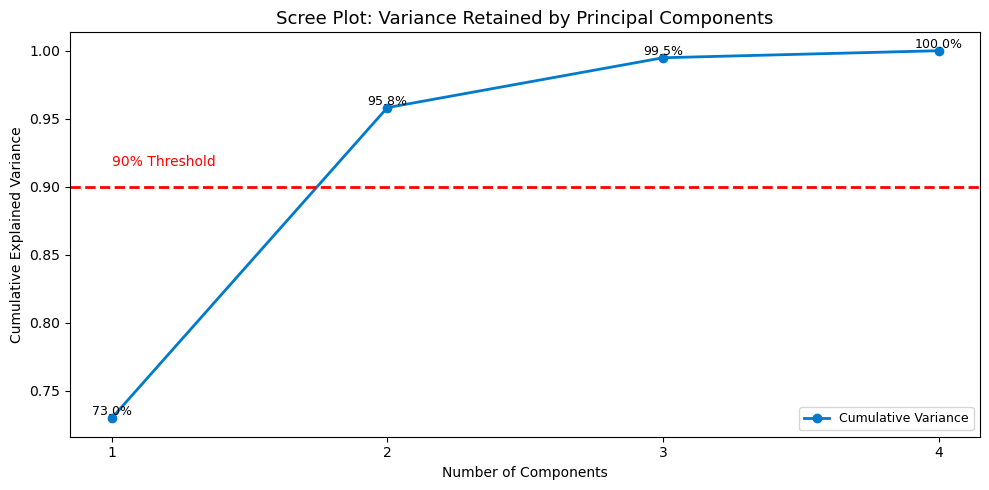

In [8]:
# Fit PCA to get all components
pca_scree_plot = PCA()
pca_scree_plot.fit(scaled_data)

# Calculate cumulative explained variance
explained_variance = pca_scree_plot.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker='o',
    label='Cumulative Variance',
    linewidth=2,
    color='#007acc'
)

# Annotate percentage values
for i, var in enumerate(cumulative_variance):
    plt.text(i + 1, var, f'{var * 100:.1f}%', ha='center', va='bottom', fontsize=9)

# Bold red 90% threshold line
threshold = 0.90
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2)
plt.text(1, threshold + 0.015, f'{int(threshold * 100)}% Threshold', color='red', fontsize=10)

# Styling
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: Variance Retained by Principal Components', fontsize=13)
plt.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.show()


<a id="apply-pca"></a>
#### 📉 Apply PCA: Reducing to n Principal Components

<details><summary>📖 Click to Expand </summary>

Here, we reduce the dataset to its top n principal components using PCA. This helps in projecting high-dimensional data onto a 2D space, allowing us to visualize how well-separated the classes (species) are.

Each row in the output represents a transformed version of the original flower measurements, now compressed into `PC1` and `PC2` — the directions of highest variance in the data.
<hr style="border: none; height: 1px; background-color: #ddd;" />
</details>

In [9]:
# Fit full PCA
# pca_scree_plot = PCA()
# pca_scree_plot.fit(scaled_data)

# Get explained variance ratio and cumulative variance
explained_variance = pca_scree_plot.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print marginal gain and cumulative contribution per PC
print("Principal Component Breakdown:\n")
print(f"{'Component':<10}{'Explains':>15}{'Cumulative':>20}{'Δ Cumulative':>20}")
print("-" * 70)

for i, (individual, cumulative) in enumerate(zip(explained_variance, cumulative_variance)):
    delta_cum = cumulative if i == 0 else cumulative - cumulative_variance[i - 1]
    print(f"PC{i+1:<8}{individual * 100:>13.2f}%{cumulative * 100:>18.2f}%{delta_cum * 100:>18.2f}%")

# Business-friendly summary + automated component selector
low_gain_threshold = 0.05  # Define marginal gain threshold
selected_n_components = 1  # Always keep at least 1
print("\nBusiness-Friendly Summary:")
for i in range(len(cumulative_variance)):
    if i == 0:
        print(f"- PC1 explains {explained_variance[i]*100:.2f}% of total variance.")
    else:
        gain = cumulative_variance[i] - cumulative_variance[i - 1]
        print(f"- Adding PC{i+1} increases cumulative variance to {cumulative_variance[i]*100:.2f}% (+{gain*100:.2f}%).")        
        if gain < low_gain_threshold:
            print(f"  ⚠️  Marginal gain is low — you may consider stopping before PC{i+1}.")
            break
        else:
            selected_n_components = i + 1

print(f"\n✅ Auto-selected number of components to retain: {selected_n_components}")

Principal Component Breakdown:

Component        Explains          Cumulative        Δ Cumulative
----------------------------------------------------------------------
PC1               72.96%             72.96%             72.96%
PC2               22.85%             95.81%             22.85%
PC3                3.67%             99.48%              3.67%
PC4                0.52%            100.00%              0.52%

Business-Friendly Summary:
- PC1 explains 72.96% of total variance.
- Adding PC2 increases cumulative variance to 95.81% (+22.85%).
- Adding PC3 increases cumulative variance to 99.48% (+3.67%).
  ⚠️  Marginal gain is low — you may consider stopping before PC3.

✅ Auto-selected number of components to retain: 2


In [10]:
# Apply PCA
pca = PCA(n_components=selected_n_components)  # Reduce to n components for visualization
pca_result = pca.fit_transform(scaled_data)

# Convert results to DataFrame
pc_labels = [f'PC{i+1}' for i in range(selected_n_components)]
pca_df = pd.DataFrame(data=pca_result, columns=pc_labels)
pca_df

# Add target labels for visualization (optional)
# pca_df['Target'] = iris.target

,PC1,PC2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


<a id="pca-loadings"></a>
#### 📊 PCA Loadings: Feature Contributions

<details><summary>📖 Click to Expand </summary>

Loadings tell us how much each original feature contributes to each principal component. Think of it as a weighted recipe:

> PC1 = 0.52 × petal length − 0.28 × sepal width + ...

These values help interpret what each component actually means.

Note: The **sum of squared loadings per PC** is always ~1, due to PCA’s mathematical properties (unit vectors).
</details>


In [11]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=df.select_dtypes(include=[np.number]).columns)

print("PCA Loadings:")
print(loadings)

# Sanity check: sum of squared loadings for each PC ≈ 1
print("\nSum of Squared Loadings per PC:")
print((loadings**2).sum(axis=0))

PCA Loadings:
                        PC1       PC2
sepal length (cm)  0.521066  0.377418
sepal width (cm)  -0.269347  0.923296
petal length (cm)  0.580413  0.024492
petal width (cm)   0.564857  0.066942

Sum of Squared Loadings per PC:
PC1    1.0
PC2    1.0
dtype: float64


In [12]:
print("📐 PCA Component Equations:\n")

for pc in loadings.columns:
    coeffs = loadings[pc]
    terms = []
    
    for i, (feature, coeff) in enumerate(coeffs.items()):
        sign = "−" if coeff < 0 else "+"  # Note: en-dash for clean minus
        formatted = f"{abs(coeff):.2f} × {feature}"
        if i == 0:
            terms.append(f"{formatted}" if coeff >= 0 else f"− {formatted}")
        else:
            terms.append(f"{sign} {formatted}")
    
    equation = " ".join(terms)
    print(f"{pc} = {equation}\n")

📐 PCA Component Equations:

PC1 = 0.52 × sepal length (cm) − 0.27 × sepal width (cm) + 0.58 × petal length (cm) + 0.56 × petal width (cm)

PC2 = 0.38 × sepal length (cm) + 0.92 × sepal width (cm) + 0.02 × petal length (cm) + 0.07 × petal width (cm)



<a id="pca-visuals"></a>
#### 📊 Visualizing Feature Contributions to PCAs

<details><summary>📖 Click to Expand </summary>
These plots help us interpret PCA results more intuitively:

- The **first plot** shows raw loadings — how much each original feature contributes to each PC.
- The **second plot** shows how each original feature's variance is split across PCs (squared loadings).
- The **third plot** flips the view: it shows how each principal component is built from the original features.

Together, they help us answer:  
> "What are these principal components *really made of*?"
</details>

`Raw Loadings Plot` (Feature contribution + direction)

/var/folders/dg/01ppfw3n6_jbnx4xdx0vdmj40000gn/T/ipykernel_4050/1736477496.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')  # Use 'Set1', 'tab20', etc. for variety


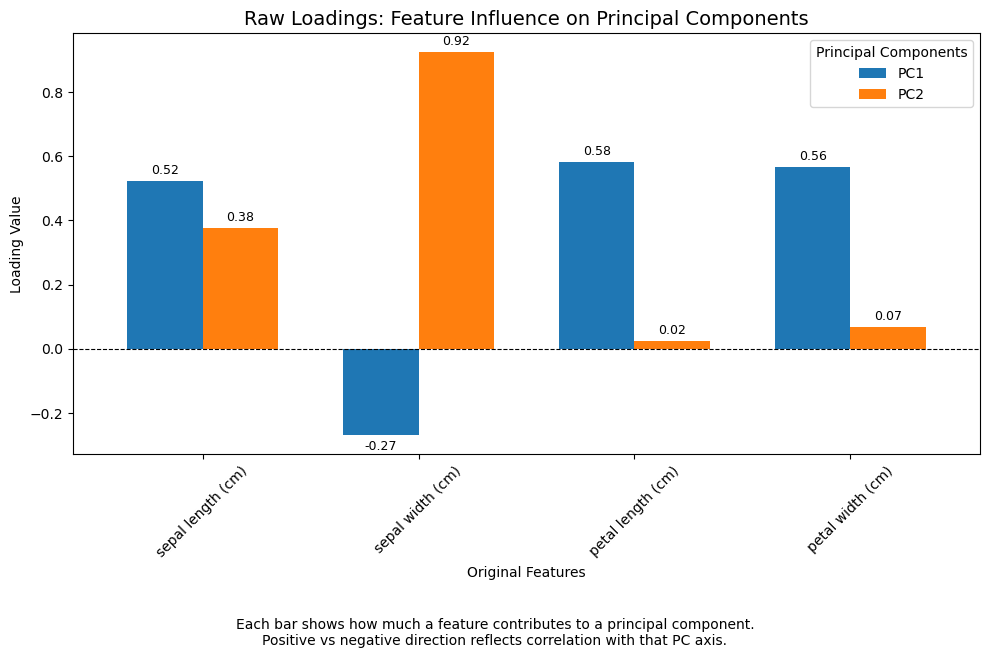

In [13]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Generate color palette based on number of PCs
cmap = get_cmap('tab10')  # Use 'Set1', 'tab20', etc. for variety
num_pcs = len(loadings.columns)
colors = [cmap(i) for i in range(num_pcs)]

# Create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = loadings.plot(kind='bar', ax=ax, width=0.7, color=colors)

# Plot settings
ax.set_title('Raw Loadings: Feature Influence on Principal Components', fontsize=14)
ax.set_ylabel('Loading Value')
ax.set_xlabel('Original Features')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.legend(title="Principal Components")
plt.xticks(rotation=45)

# Add numeric annotations on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

# Add explanation text under the plot
plt.figtext(
    0.5, -0.08,
    "Each bar shows how much a feature contributes to a principal component.\n"
    "Positive vs negative direction reflects correlation with that PC axis.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10
)

plt.tight_layout()
plt.show()


`Feature-wise Stacked Plot` (How each feature is explained across PCs)

/var/folders/dg/01ppfw3n6_jbnx4xdx0vdmj40000gn/T/ipykernel_4050/480588593.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


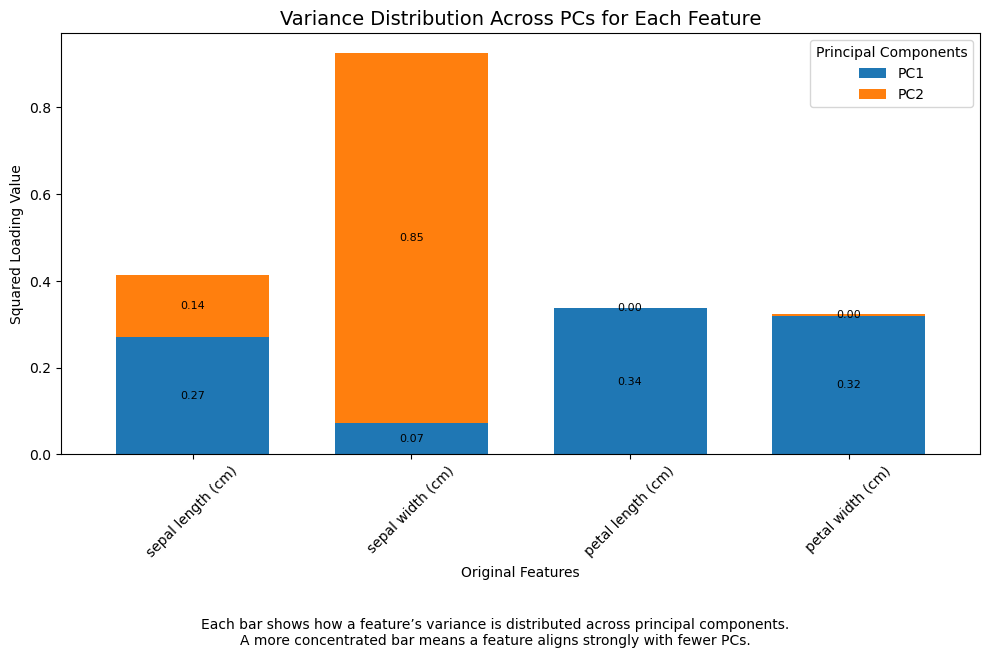

In [14]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Compute squared loadings
squared_loadings = loadings ** 2

# Generate dynamic color palette
num_pcs = squared_loadings.shape[1]
cmap = get_cmap('tab10')
colors = [cmap(i) for i in range(num_pcs)]

# Create stacked bar chart (feature-wise variance contribution)
fig, ax = plt.subplots(figsize=(10, 6))
bars = squared_loadings.plot(kind='bar', stacked=True, ax=ax, width=0.7, color=colors)

# Formatting
ax.set_title('Variance Distribution Across PCs for Each Feature', fontsize=14)
ax.set_ylabel('Squared Loading Value')
ax.set_xlabel('Original Features')
ax.legend(title="Principal Components")
plt.xticks(rotation=45)

# Annotate center of each segment
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

# Generic explanation
plt.figtext(
    0.5, -0.08,
    "Each bar shows how a feature’s variance is distributed across principal components.\n"
    "A more concentrated bar means a feature aligns strongly with fewer PCs.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10
)

plt.tight_layout()
plt.show()


`PC-wise Stacked Plot` (What each PC is made of)

/var/folders/dg/01ppfw3n6_jbnx4xdx0vdmj40000gn/T/ipykernel_4050/1328071015.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # Wider palette for more features


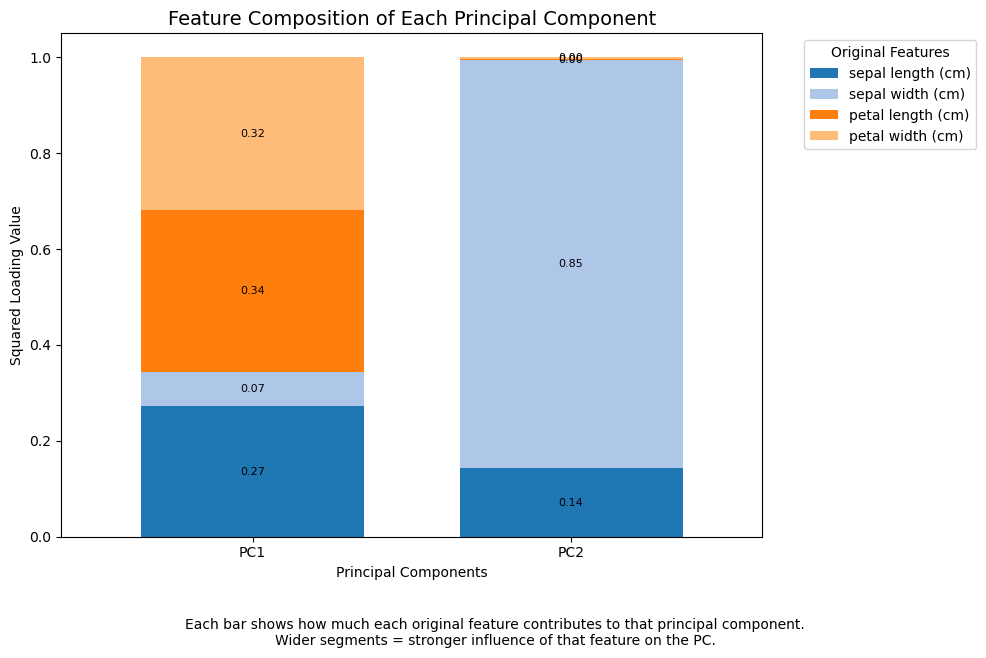

In [15]:
from matplotlib.cm import get_cmap

# Transpose squared loadings: PCs on x-axis, features as stack
squared_T = squared_loadings.T

# Dynamically generate colors based on feature count
num_features = squared_T.shape[1]
cmap = get_cmap('tab20')  # Wider palette for more features
colors = [cmap(i) for i in range(num_features)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = squared_T.plot(kind='bar', stacked=True, ax=ax, width=0.7, color=colors)

# Styling
ax.set_title('Feature Composition of Each Principal Component', fontsize=14)
ax.set_ylabel('Squared Loading Value')
ax.set_xlabel('Principal Components')
ax.legend(title="Original Features", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Annotate each bar segment
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

# Explanation
plt.figtext(
    0.5, -0.08,
    "Each bar shows how much each original feature contributes to that principal component.\n"
    "Wider segments = stronger influence of that feature on the PC.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10
)

plt.tight_layout()
plt.show()


<a id="pca-2d-scatter"></a>
#### 🧭 Visualizing PCA Results in 2D

<details><summary>📖 Click to Expand </summary>

This scatter plot projects the Iris dataset onto the first two principal components (PC1 and PC2).

- Each point is a flower
- Colors represent the original species labels
- The separation between clusters tells us how well PCA captures the differences

Notice how **Setosa** is linearly separable, while **Versicolor** and **Virginica** overlap slightly — just like the original feature space.

This view is helpful for:
- Visual intuition
- Early clustering
- Pre-model dimensionality checks
</details>

In [16]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_pca_projection(pca_df, target_col=None, dim=2, fallback_to_2d=True):
    """
    Visualizes PCA projection in 2D or 3D space.
    
    Parameters:
    - pca_df: DataFrame with PCA result columns (PC1, PC2, [PC3])
    - target_col: str or None — optional column for coloring/grouping
    - dim: int — 2 or 3
    - fallback_to_2d: if True and 3D not possible, auto-downgrade to 2D
    
    Raises:
    - ValueError if required PC columns are missing and fallback is False
    """
    assert dim in [2, 3], "Only 2D or 3D plots are supported."
    
    pcs = [f'PC{i+1}' for i in range(dim)]
    missing_pcs = [pc for pc in pcs if pc not in pca_df.columns]

    if missing_pcs:
        if fallback_to_2d and dim == 3:
            print(f"⚠️ PC3 not found. Falling back to 2D projection.")
            return plot_pca_projection(pca_df, target_col=target_col, dim=2, fallback_to_2d=False)
        else:
            raise ValueError(f"PCA DataFrame must contain columns: {pcs}")
    
    # Setup plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d' if dim == 3 else None)

    # Determine coloring logic
    if target_col and target_col in pca_df.columns:
        groups = pca_df[target_col].unique()
        cmap = get_cmap('Set1', len(groups))
        colors = [cmap(i) for i in range(len(groups))]

        for group, color in zip(groups, colors):
            subset = pca_df[pca_df[target_col] == group]
            coords = [subset[pc] for pc in pcs]
            ax.scatter(*coords, label=group, color=color, alpha=0.7, edgecolor='k', s=60)
    else:
        coords = [pca_df[pc] for pc in pcs]
        ax.scatter(*coords, color='steelblue', alpha=0.7, edgecolor='k', s=60)

    # Titles and labels
    ax.set_title(f'PCA Projection ({dim}D)', fontsize=14)
    ax.set_xlabel(pcs[0], fontsize=12)
    ax.set_ylabel(pcs[1], fontsize=12)
    if dim == 3:
        ax.set_zlabel(pcs[2], fontsize=12)
    else:
        ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='grey', linewidth=0.5, linestyle='--')

    if target_col and target_col in pca_df.columns:
        ax.legend(title=target_col, fontsize=9)

    plt.tight_layout()
    plt.show()


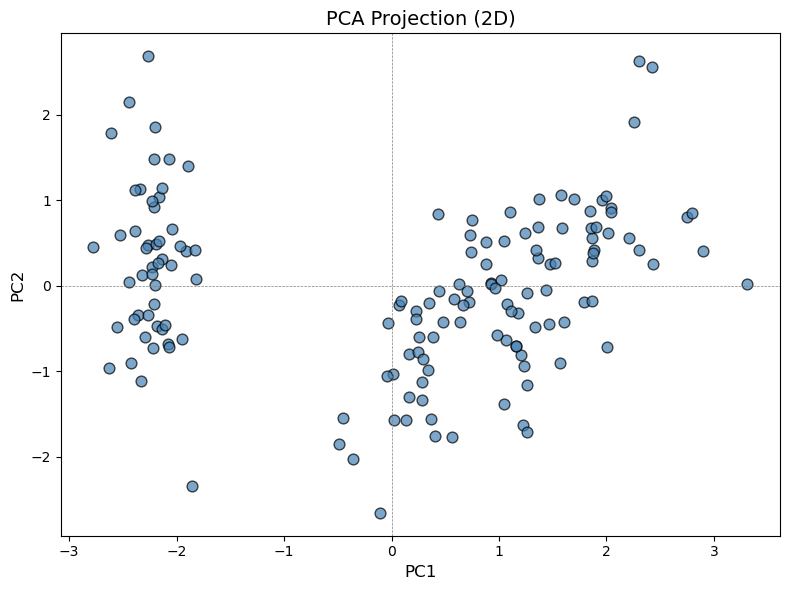

In [17]:
# 🟦 2D PCA without any target grouping (all points same color)
plot_pca_projection(pca_df, dim=2)

# 🟨 2D PCA with target-based color grouping (e.g. segment, species, etc.)
# Make sure to attach the original target/segment column from the full dataset
# pca_df['segment'] = df['segment'].values
# plot_pca_projection(pca_df, target_col='segment', dim=2)

# 🟥 3D PCA plot (if at least 3 principal components exist)
# Will automatically downgrade to 2D if PC3 is missing
# plot_pca_projection(pca_df, target_col='segment', dim=3)


<a id="variance-explained"></a>
#### 📈 Variance Explained by Each Component

<details><summary>📖 Click to Expand </summary>

This section quantifies how much information (variance) is retained by each principal component.

- **Explained Variance**: The proportion of total variance captured by that component
- **Cumulative Variance**: How much total variance is retained up to that point

This helps determine how many components are needed to preserve most of the original data’s structure.
</details>

In [18]:
# Explained variance by each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("📊 Variance Explained by Principal Components:\n")

for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance), start=1):
    if i == 1:
        print(f"• PC{i} alone explains {ev*100:.2f}% of the total variance.")
    else:
        delta = ev * 100
        print(f"• Adding PC{i} contributes an additional {delta:.2f}%, bringing cumulative variance to {cv*100:.2f}%.")

📊 Variance Explained by Principal Components:

• PC1 alone explains 72.96% of the total variance.
• Adding PC2 contributes an additional 22.85%, bringing cumulative variance to 95.81%.


<a id="pca-before-after"></a>
#### 🧾 Visual Comparison: Original vs PCA-Transformed Data

In [19]:
from IPython.display import display, HTML

# Limit to first 5 rows for visual comparison
original = df.select_dtypes(include=[np.number]).sample(10, random_state=42)
transformed = pca_df.loc[original.index]  # Keep rows aligned

# Convert to HTML with inline styling
html = f"""
<div style="display: flex; gap: 40px;">
  <div>
    <h4>📥 Original Data</h4>
    {original.to_html(index=False)}
  </div>
  <div>
    <h4>📤 PCA-Transformed Data</h4>
    {transformed.to_html(index=False)}
  </div>
</div>
"""
display(HTML(html))

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
6.1,2.8,4.7,1.2
5.7,3.8,1.7,0.3
7.7,2.6,6.9,2.3
6.0,2.9,4.5,1.5
6.8,2.8,4.8,1.4
5.4,3.4,1.5,0.4
5.6,2.9,3.6,1.3
6.9,3.1,5.1,2.3
6.2,2.2,4.5,1.5
5.8,2.7,3.9,1.2


[Back to the top](#table-of-contents)
___



<a id="tsne"></a>
# 🌌 t-SNE (t-Distributed Stochastic Neighbor Embedding)



<a id="tsne-intuition"></a>
#### 🔍 Intuition

<details><summary>📖 Click to Expand </summary>

t-SNE (t-distributed Stochastic Neighbor Embedding) is a technique for reducing high-dimensional data into 2 or 3 dimensions — but unlike PCA, it's **non-linear** and focused entirely on **preserving local structure**.

At its core, t-SNE is not about simplifying the data for modeling — it's about **revealing patterns you can see**.

- Instead of preserving distances or variance (like PCA), t-SNE preserves **neighborhoods** — points that are close in high dimensions stay close in the 2D/3D map.
- It's most commonly used for **visualizing latent patterns**, especially in cases where traditional methods like PCA fail to reveal clusters.
- It's powerful for exploring **highly non-linear**, **non-separable** data — such as text embeddings, image features, or user behavior vectors.

Think of it as:
> “How can we map this complex space into something that’s *visually meaningful* — even if it’s mathematically warped?”

t-SNE doesn't give you a formula, axes you can interpret, or transformed features you can use in models. But it gives you **insight** — which is often the first thing you need.
</details>

<a id="when-to-use-tsne"></a>
#### 🎯 When Should You Use t-SNE?

<details><summary>📖 Click to Expand </summary>


t-SNE shines in specific scenarios where interpretability and visualization of complex data are more important than feature transformation.

- 🧠 **Exploring High-Dimensional Patterns**  
  Use it when traditional plots or summary stats fail to reveal clusters, separation, or structure.

- 👁️ **Human-Centric Visualizations**  
  Great for dashboards, presentations, or storytelling where you want to show “how your data looks” after compression.

- 🧪 **Unsupervised Insight Discovery**  
  Use it during early EDA to detect latent groups in unlabeled data (e.g., customer personas, image clusters).

- 🧭 **Validating Cluster Separation**  
  Complement with KMeans or DBSCAN to visually confirm if your clusters are distinct in embedded space.

- 📊 **Working with Complex Data Types**  
  t-SNE works well on word embeddings, image embeddings, or any data where relationships aren’t linear.

> 🔗 Use t-SNE when you're looking for **shape**, not **predictive power**.
<details>

<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="how-tsne-works"></a>
#### ⚙️ How It Works

<details><summary>📖 Click to Expand </summary>

t-SNE works by modeling the **pairwise relationships** between data points in both the original high-dimensional space and the reduced 2D (or 3D) space.

The goal is simple:  
> If two points are **close together** in the original space, they should also be close in the visualization.

Here's a high-level breakdown:

1. **Measure Similarities in High Dimensions**  
   - It computes how similar each point is to others using a probability based on distance (think: "who are my neighbors?").
   - It uses a parameter called `perplexity` to control how many neighbors matter.

2. **Map into Lower Dimensions**  
   - It starts with a random 2D/3D layout of the points.
   - Then, it tries to make the new layout **mimic the neighborhood probabilities** from the original space.

3. **Optimize the Layout**  
   - It uses a process that pulls similar points together and pushes dissimilar ones apart.
   - The optimization minimizes a loss function (KL Divergence) that measures how different the low-dimensional relationships are from the high-dimensional ones.

The final result:
- A 2D (or 3D) scatter plot where **closeness means similarity**.
- It’s great for uncovering hidden structure, clusters, and anomalies — even when those relationships are non-linear or tangled.
<hr style="border: none; height: 1px; background-color: #ddd;" />


In [20]:
from sklearn.manifold import TSNE

# Automatically select only numeric columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.select_dtypes(include=[np.number]))
scaled_data[0:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

<a id="tsne-hyperparams"></a>
#### 🧪 Key Parameters and Tuning Tips

<details><summary>📖 Click to Expand </summary>

t-SNE is a sensitive algorithm — small changes in parameters can lead to dramatically different results. Here's how to tune it effectively without trial-and-error chaos:

**1. `perplexity`**  
- Think of it as the **expected number of neighbors** each point considers.
- Typical range: **5 to 50**.  
- Low values (e.g. 5–10): good for very **tight clusters**.  
- Higher values (e.g. 30–50): useful for **smoother global structure**.

🧠 *Tip: Too low = fragmented plot. Too high = clusters blur into each other.*

**2. `n_iter`**  
- Number of optimization iterations.  
- Default is 1000 — often enough, but **use 2000+ for better stability**.

🧠 *Tip: You’ll often see t-SNE stabilize around 750–1000 iterations, but complex data needs more.*

**3. `learning_rate`**  
- Controls how fast t-SNE updates positions.  
- Can be tricky — if set too high or too low, it can stall or explode.  
- Safe starting point: **200 to 500**.

🧠 *Tip: If your plot collapses into a ball or becomes linear, try tweaking this.*

**4. `init`**  
- Controls the starting layout:  
  - `'random'`: faster, riskier  
  - `'pca'`: slower, often **more stable**

🧠 *Tip: PCA initialization can make results more consistent across runs.*

**5. `random_state`**  
- Set this to ensure **reproducible results**. t-SNE is stochastic.

🧠 *Tip: Always fix this when sharing results or comparing runs.*

**🧩 Final Advice:**  
- t-SNE doesn’t optimize interpretability — it optimizes **relative closeness**.
- The result is a **visual aid**, not a numerical transformation.
- Always validate your plot: **Do the clusters make sense? Do they hold across reruns?**


In [21]:
#t-SNE is not a feature reducer for modeling like PCA. It’s a projection for human eyes. tsne_n_components>3 is never used
tsne_n_components = 2

tsne = TSNE(
    n_components=tsne_n_components,
    perplexity=30,
    n_iter=1000,
    learning_rate=200,
    init='pca',
    random_state=42
)
tsne_result = tsne.fit_transform(scaled_data)

# Auto-generate column names: t-SNE1, t-SNE2, ...
tsne_cols = [f"t-SNE{i+1}" for i in range(tsne_n_components)]
tsne_df = pd.DataFrame(tsne_result, columns=tsne_cols)
tsne_df

,t-SNE1,t-SNE2
0,17.524487,10.526419
1,13.745171,10.214914
2,14.959588,9.684340
3,14.277590,9.399287
4,17.879566,11.128079
...,...,...
145,-13.833820,-5.847079
146,-6.999432,-7.042307
147,-12.770849,-5.746600
148,-14.140002,-7.868678


<a id="tsne-visuals"></a>
#### 📊 Visualizing t-SNE Output

In [22]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_projection(tsne_df, target_col=None):
    """
    Plots t-SNE output in 2D or 3D depending on number of components available.
    Colors by target_col if provided and valid. Always prints how many components are being plotted.
    """
    tsne_cols = [col for col in tsne_df.columns if col.startswith('t-SNE')]
    n_components = len(tsne_cols)

    if n_components < 2:
        raise ValueError(f"❌ Found only {n_components} t-SNE component(s). Need at least 2 to plot.")

    if n_components >= 3:
        print(f"📢 Found {n_components} t-SNE components — plotting the first 3 in 3D.")
        x_col, y_col, z_col = tsne_cols[:3]
        
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        if target_col and target_col in tsne_df.columns:
            unique_vals = tsne_df[target_col].unique()
            colors = plt.cm.get_cmap('Set1', len(unique_vals)).colors

            for val, color in zip(unique_vals, colors):
                subset = tsne_df[tsne_df[target_col] == val]
                ax.scatter(subset[x_col], subset[y_col], subset[z_col],
                           label=val, color=color, alpha=0.7, s=60, edgecolor='k')
            ax.legend(title=target_col)
        else:
            if target_col:
                print(f"⚠️ Column '{target_col}' not found. Falling back to plain scatter.")
            ax.scatter(tsne_df[x_col], tsne_df[y_col], tsne_df[z_col],
                       color='steelblue', alpha=0.7, s=60, edgecolor='k')

        ax.set_title('t-SNE Projection (3D)', fontsize=14)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        plt.tight_layout()
        plt.show()

    else:
        print(f"📢 Found {n_components} t-SNE components — plotting in 2D.")
        x_col, y_col = tsne_cols[:2]
        plt.figure(figsize=(8, 6))

        if target_col and target_col in tsne_df.columns:
            unique_vals = tsne_df[target_col].unique()
            colors = plt.cm.get_cmap('Set1', len(unique_vals)).colors

            for val, color in zip(unique_vals, colors):
                subset = tsne_df[tsne_df[target_col] == val]
                plt.scatter(subset[x_col], subset[y_col], label=val,
                            color=color, alpha=0.7, edgecolor='k', s=60)
            plt.legend(title=target_col, fontsize=10)
        else:
            if target_col:
                print(f"⚠️ Column '{target_col}' not found. Falling back to plain scatter.")
            plt.scatter(tsne_df[x_col], tsne_df[y_col], alpha=0.7,
                        color='steelblue', edgecolor='k', s=60)

        plt.title('t-SNE Projection (2D)', fontsize=14)
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='grey', linewidth=0.5, linestyle='--')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


📢 Found 2 t-SNE components — plotting in 2D.


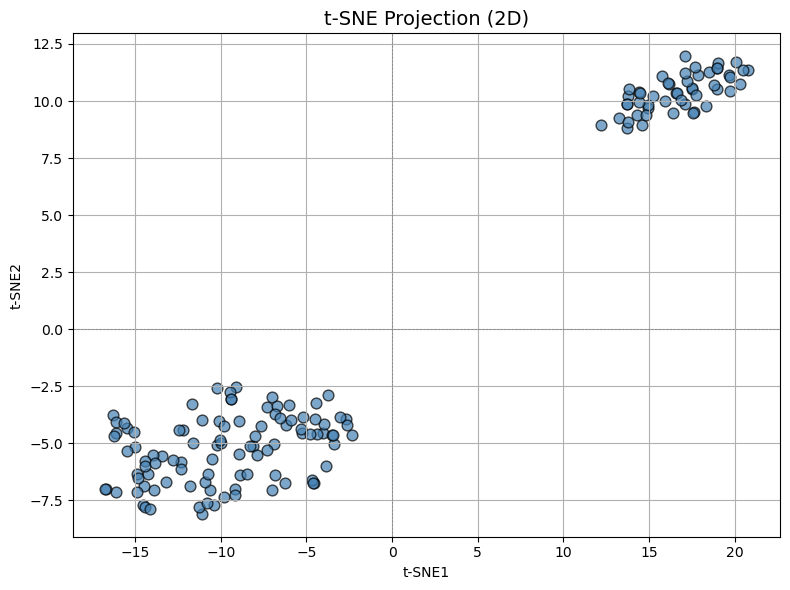

📢 Found 2 t-SNE components — plotting in 2D.
⚠️ Column 'segment' not found. Falling back to plain scatter.


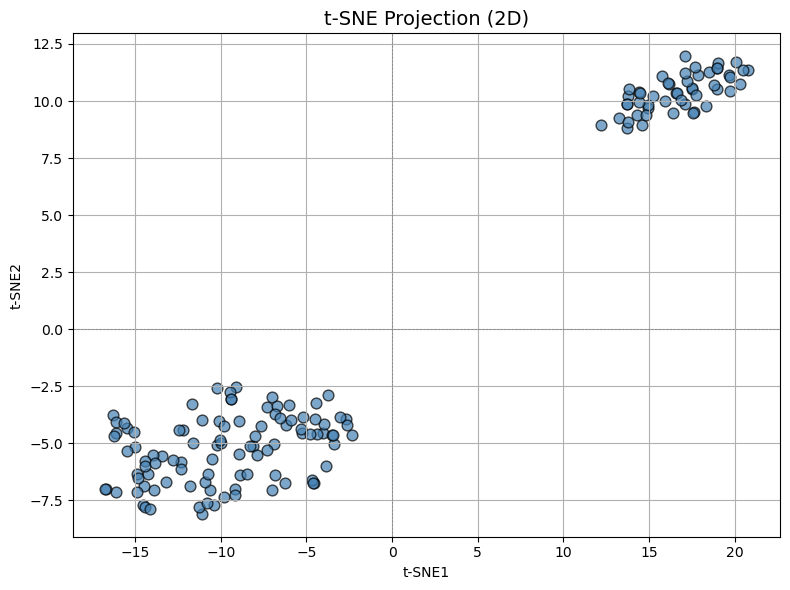

In [23]:
plot_tsne_projection(tsne_df)  # Plain scatter
plot_tsne_projection(tsne_df, target_col='segment')  # Colored by group

##### 🌐 KDE Density Plot (Optional Enhancement)

In [24]:
def plot_tsne_density(tsne_df):
    tsne_cols = [col for col in tsne_df.columns if col.startswith('t-SNE')]

    if len(tsne_cols) < 2:
        print(f"❌ Density plot skipped — requires at least 2 t-SNE components, found {len(tsne_cols)}.")
        return
    elif len(tsne_cols) > 2:
        print(f"⚠️ Found {len(tsne_cols)} t-SNE components — plotting only the first two: {tsne_cols[:2]}")

    x_col, y_col = tsne_cols[:2]

    plt.figure(figsize=(8, 6))
    sns.kdeplot(x=tsne_df[x_col], y=tsne_df[y_col], fill=True, cmap='Blues')
    plt.title('Density Plot of t-SNE Outputs')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid()
    plt.tight_layout()
    plt.show()

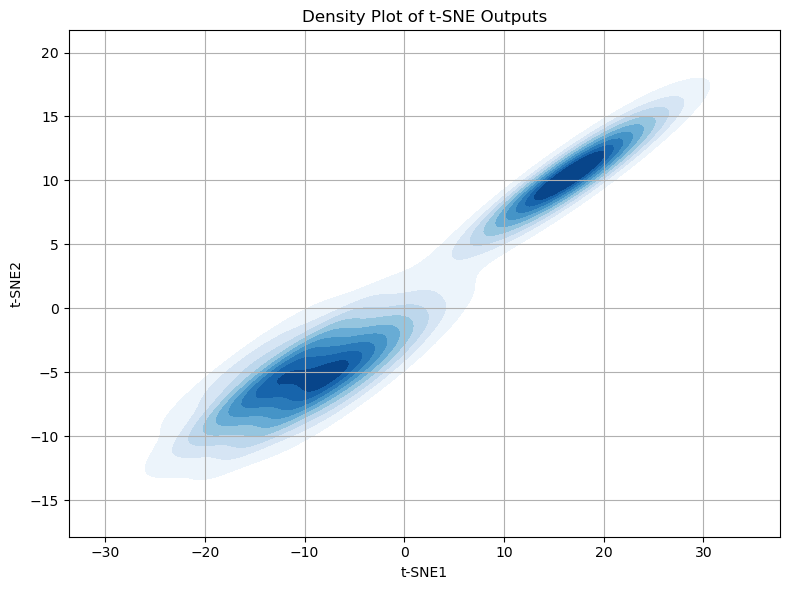

In [25]:
plot_tsne_density(tsne_df)

##### 🧱 Clustering in t-SNE Space (e.g., KMeans)

Use clustering algorithms like KMeans on t-SNE output to assign structure to the 2D projection.

- 📌 **Purpose**: Quantify and visualize the clusters that naturally emerge in the t-SNE space.
- 🧠 **Why it’s useful**: t-SNE creates a visual layout — clustering converts that into actionable segments.
- 🎯 **When to use**: Helpful when original labels are missing, or when validating that t-SNE separated meaningful groups.

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

def cluster_tsne(tsne_df, n_clusters=None, cluster_col='Cluster', max_k=10):
    """
    Runs KMeans on first 2 t-SNE components and visualizes clusters.
    If n_clusters is None, auto-selects best k using silhouette score.
    """
    tsne_cols = [col for col in tsne_df.columns if col.startswith('t-SNE')]
    
    if len(tsne_cols) < 2:
        print(f"❌ Clustering skipped — need at least 2 t-SNE dimensions, found {len(tsne_cols)}.")
        return

    x_col, y_col = tsne_cols[:2]
    X_cluster = tsne_df[[x_col, y_col]]

    # Auto-determine optimal k
    if n_clusters is None:
        print("ℹ️ No cluster count provided — finding optimal k using silhouette score...")
        scores = {}
        for k in range(2, max_k + 1):
            model = KMeans(n_clusters=k, random_state=42).fit(X_cluster)
            score = silhouette_score(X_cluster, model.labels_)
            scores[k] = score
        n_clusters = max(scores, key=scores.get)
        print(f"✅ Best k based on silhouette score: {n_clusters}")

    # Handle existing column
    if cluster_col in tsne_df.columns:
        print(f"⚠️ Cluster column '{cluster_col}' already exists. Overwriting...")

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    tsne_df[cluster_col] = kmeans.fit_predict(X_cluster)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=tsne_df, x=x_col, y=y_col, hue=cluster_col, palette='Set1', alpha=0.7, edgecolor='k')
    plt.title(f't-SNE with KMeans Clustering (k = {n_clusters})', fontsize=14)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend(title="Cluster", fontsize=10)
    plt.grid()
    plt.tight_layout()
    plt.show()

ℹ️ No cluster count provided — finding optimal k using silhouette score...
✅ Best k based on silhouette score: 2


/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warning

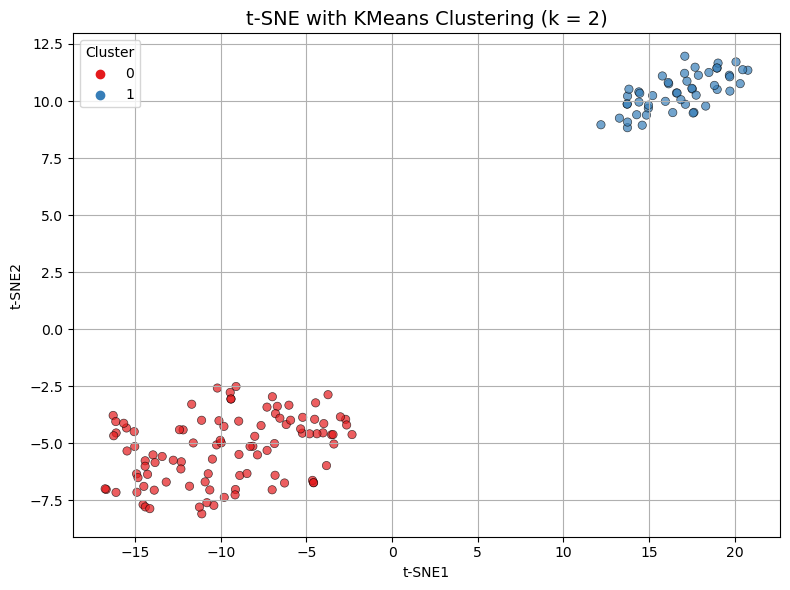

⚠️ Cluster column 'Cluster' already exists. Overwriting...


/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


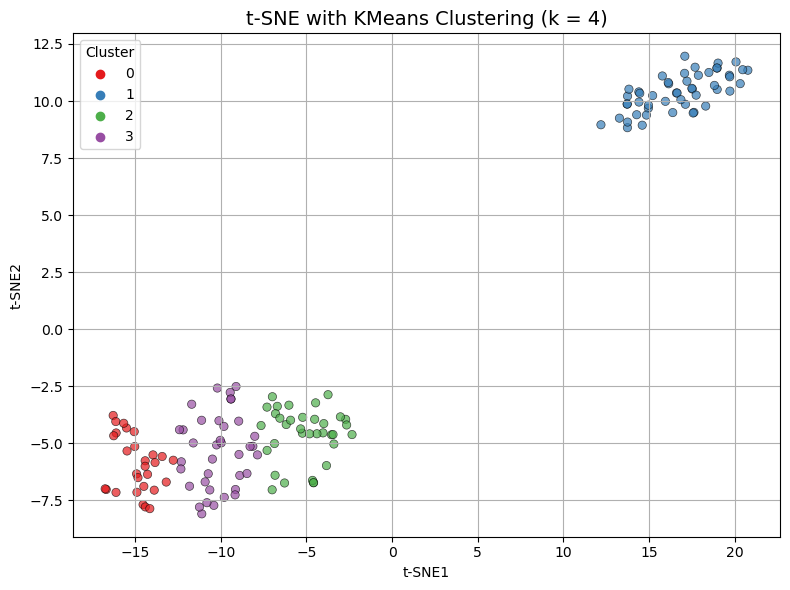

In [27]:
cluster_tsne(tsne_df)  # Auto-k based on silhouette
cluster_tsne(tsne_df, n_clusters=4)  # Manual override

##### 🎨 t-SNE Colored by a Feature (Optional Insight)

Overlay a specific feature's values (e.g., `sepal length`, `spend`, `churn_score`) onto the t-SNE projection using a color gradient.

- 📌 **Purpose**: Reveal how a particular feature correlates with t-SNE layout. Useful for understanding which regions of the plot correspond to high or low values.
- 🎯 **When to use**: After clustering or t-SNE visualization, to enrich the plot with **business-relevant** or **domain-specific** signals.
- 🧠 **Best with**: Continuous features (e.g., spend, age, price, interaction time)

In [28]:
def plot_tsne_by_feature(tsne_df, df, feature_col=None):
    """
    Visualizes t-SNE projection colored by a specific feature (continuous or categorical).
    
    - tsne_df: DataFrame with t-SNE columns (e.g., t-SNE1, t-SNE2, ...)
    - df: Original DataFrame containing the feature
    - feature_col: Name of the column to visualize (optional). If None, uses first numeric column.
    """
    tsne_cols = [col for col in tsne_df.columns if col.startswith('t-SNE')]

    if len(tsne_cols) < 2:
        print("❌ Cannot plot — t-SNE must have at least 2 components.")
        return

    if feature_col is None:
        numeric_cols = df.select_dtypes(include='number').columns
        if len(numeric_cols) == 0:
            print("❌ No numeric feature found in DataFrame to color by.")
            return
        feature_col = numeric_cols[0]
        print(f"ℹ️ No feature provided — defaulting to first numeric column: '{feature_col}'")

    if feature_col not in df.columns:
        print(f"❌ Feature '{feature_col}' not found in DataFrame.")
        return

    feature = df[feature_col]
    x_col, y_col = tsne_cols[:2]

    plt.figure(figsize=(8, 6))

    if pd.api.types.is_numeric_dtype(feature):
        scatter = plt.scatter(
            tsne_df[x_col],
            tsne_df[y_col],
            c=feature,
            cmap='coolwarm',
            edgecolor='k',
            alpha=0.7,
            s=60
        )
        plt.colorbar(scatter, label=feature_col)
    else:
        unique_vals = feature.unique()
        colors = plt.cm.get_cmap('Set1', len(unique_vals)).colors
        for val, color in zip(unique_vals, colors):
            subset = tsne_df[feature == val]
            plt.scatter(
                subset[x_col],
                subset[y_col],
                label=val,
                color=color,
                alpha=0.7,
                edgecolor='k',
                s=60
            )
        plt.legend(title=feature_col)

    plt.title(f't-SNE Colored by {feature_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

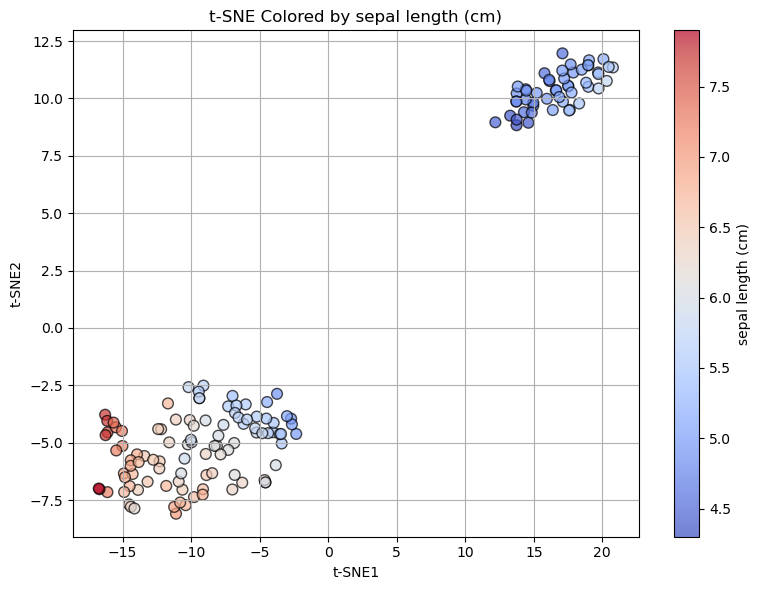

/var/folders/dg/01ppfw3n6_jbnx4xdx0vdmj40000gn/T/ipykernel_4050/1409261539.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1', len(unique_vals)).colors


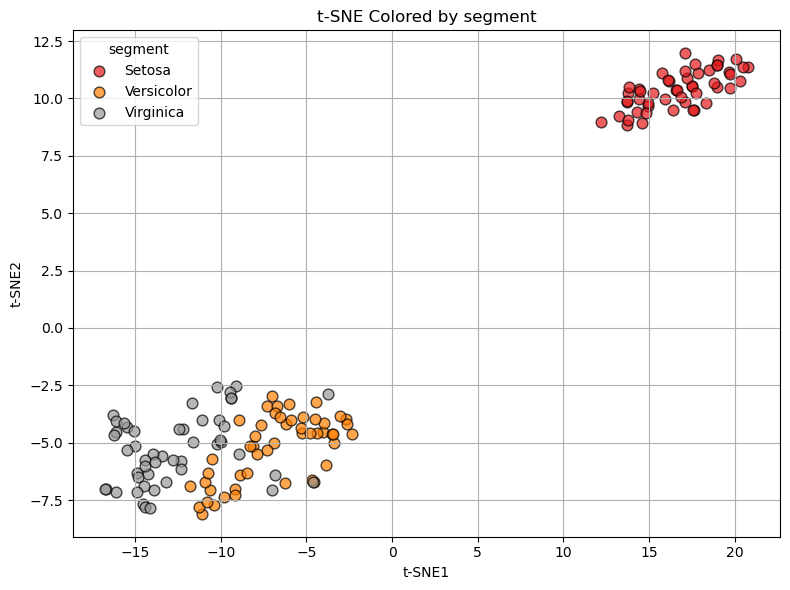

ℹ️ No feature provided — defaulting to first numeric column: 'sepal length (cm)'


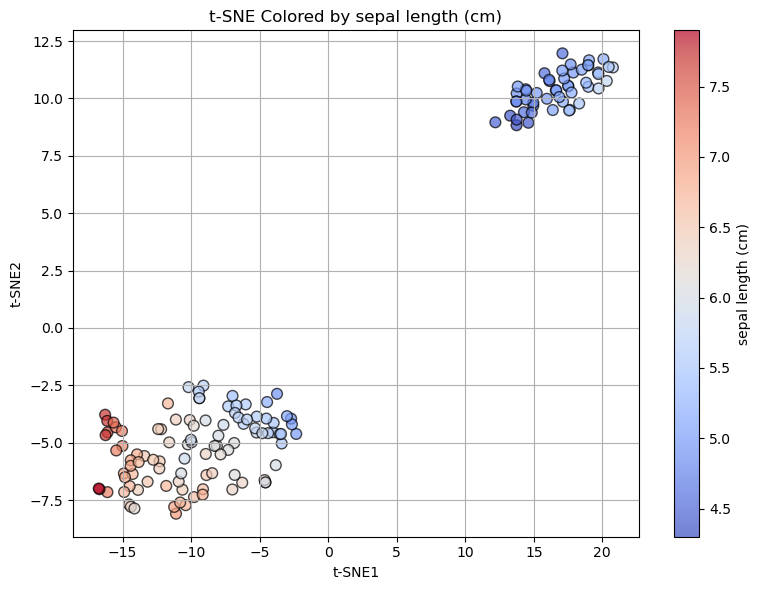

❌ Feature 'nonexistent_column' not found in DataFrame.


In [29]:
plot_tsne_by_feature(tsne_df, df, feature_col='sepal length (cm)')  # Specific continuous column
plot_tsne_by_feature(tsne_df, df, 'segment')             # Specific categorical 
plot_tsne_by_feature(tsne_df, df) # Defaults to first numeric
plot_tsne_by_feature(tsne_df, df, 'nonexistent_column')  # Clean error

<a id="tsne-limitations"></a>
#### 🚫 Limitations and Cautions

<details><summary>📖 Click to Expand </summary>

While t-SNE is powerful for visualizing high-dimensional data, it comes with several important limitations:

- ⚠️ **Not for Feature Reduction**: t-SNE is designed for visualization, not downstream modeling. The transformed axes (`t-SNE1`, `t-SNE2`, etc.) do not retain global structure or interpretability.
- 🧭 **Distances Are Local**: Only local neighborhoods are meaningful. A small distance between two points means they're similar — but large distances mean nothing.
- 🎲 **Randomness**: t-SNE is stochastic. Results can vary across runs unless `random_state` is fixed.
- 🐌 **Scalability**: It's computationally expensive and doesn’t scale well to very large datasets (>10,000 rows) without approximate variants.
- 🎛️ **Hyperparameter Sensitivity**: Results change dramatically with `perplexity`, `learning_rate`, and `n_iter`. There’s no universal rule for setting these — experimentation is key.
- 💥 **Can't Generalize to New Data**: There's no `.transform()` method. You can’t apply a fitted t-SNE to new/unseen data.

> 🔍 Use t-SNE primarily as a **visual insight tool**, not a feature engineering method.

</details>

[Back to the top](#table-of-contents)
___



<a id="umap"></a>
# 🌐 UMAP (Uniform Manifold Approximation & Projection)
<details><summary>📖 Click to Expand </summary>


**UMAP** (Uniform Manifold Approximation and Projection) is a **non-linear dimensionality reduction technique** used for visualizing high-dimensional data.  
- It creates a **graph** of data points based on local relationships and then **optimizes** the layout in a lower-dimensional space (2D or 3D), preserving both local and global structure.

**🌟 Key Benefits**:  
  - **Speed**: UMAP is faster than t-SNE, especially on large datasets.
  - **Scalability**: Efficient on large datasets, outperforming t-SNE and PCA as data grows.
  - **Reusability**: Can apply to new data via `.transform()` without retraining.
  - **Local & Global Structure**: Captures both **local** relationships (clusters) and **global patterns** (distances between clusters).
  - **Flexibility**: Reduces data to **2D**, **3D**, or higher dimensions based on analysis needs.
  - **Performance**: Handles large datasets and produces meaningful embeddings efficiently.

**📍Key Use Cases**:
  - **Data Visualization**: Reducing high-dimensional data to 2D or 3D for easy inspection.
  - **Clustering**: Visualizing data groupings and revealing hidden patterns.
  - **ML Preprocessing**: Using UMAP as a feature extraction tool before clustering, classification, or regression.
  - **EDA**: Identifying patterns, outliers, and relationships in the data.

<a id="umap-vs-tsne"></a>
#### 🔬 UMAP vs t-SNE  
<details><summary>📖 Click to Expand </summary>


🌐 What UMAP does:  
  UMAP is designed to preserve both **local** structure (relationships between nearby points) and **global** structure (relationships between distant points) in data. This makes it well-suited for uncovering both fine-grained local clusters and broader, global patterns.

🔍 UMAP vs t-SNE:
  - **t-SNE** excels at preserving **local structure**, making it effective for visualizing tight, well-separated clusters. However, it struggles with capturing **global structure**, often distorting the overall shape and relative positioning of clusters.
  - **UMAP** preserves both local and global relationships, offering a more comprehensive view of the data. This makes UMAP particularly useful when you need to capture larger-scale patterns in high-dimensional data.

🚀When to use UMAP vs t-SNE:
  - **t-SNE** is ideal for situations where **local details** are more important, and you have a relatively small dataset.
  - **UMAP** is better suited for **large datasets**, as it balances local and global structure and offers better scalability without losing important details. Choose UMAP when you need both **cluster separation** and **global context**.

<a id="how-umap-works"></a>
#### ⚙️ How UMAP Works  
<details><summary>📖 Click to Expand </summary>

UMAP (Uniform Manifold Approximation and Projection) is a non-linear dimensionality reduction technique designed to preserve the underlying structure of high-dimensional data when reducing it to lower dimensions. Here's how it works:

1. **Graph Construction** 🧑‍🔬:  
   UMAP starts by building a **graph** that captures the local relationships between data points. Points that are similar to each other are connected with strong edges, representing their proximity in the high-dimensional space. This graph captures the **local structure** of the data.

2. **Optimization in Lower Dimensions** 🔄:  
   Next, UMAP uses **stochastic gradient descent (SGD)** to optimize the layout of these points in a **lower-dimensional space** (e.g., 2D or 3D). The goal is to preserve the relationships (distances) between the points while minimizing a cost function. The optimization process adjusts the positions of points so that both **local** and some **global structures** are maintained.

3. **Preserving Local and Global Structures** 🌍:  
   Unlike t-SNE, which focuses primarily on preserving **local structure**, UMAP also retains some **global structure**. This means UMAP captures **neighborhood relationships** while also keeping broader patterns intact. This is especially useful when working with large datasets, as it provides both **fine-grained details** (local) and a **big picture view** (global).

4. **Final Embedding** 📉:  
   After the optimization, the resulting low-dimensional representation is a **set of coordinates** that reflects the original high-dimensional data in a more interpretable form. UMAP can also apply this transformation to new data using the `.transform()` method, making it a versatile tool for downstream tasks.


<a id="umap-impl"></a>
#### 🛠️ Implementation  

<details><summary>📖 Click to Expand </summary>

<a id="umap-params"></a>
##### 🎛️ Key Parameters and Tradeoffs  

- **`n_neighbors`**: Controls local vs global structure balance.  
  - **Small values**: Focus on local details (tight clusters).  
  - **Large values**: Emphasize global patterns.
- **`min_dist`**: Determines how tightly points are packed.  
  - **Small values**: Creates compact clusters.  
  - **Large values**: More spread-out clusters.
- **`n_components`**: Number of output dimensions (typically 2D for visualization, 3D for richer plots).
- **Other Parameters**: `metric`, `random_state`, etc.  
  - **Practical tuning tips** for different data types.

</details>

In [41]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

def run_umap(df, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42):
    numeric_data = df.select_dtypes(include='number')
    scaled = StandardScaler().fit_transform(numeric_data)

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=random_state
    )
    embedding = reducer.fit_transform(scaled)
    return pd.DataFrame(embedding, columns=[f"UMAP_{i+1}" for i in range(n_components)])

umap_2d = run_umap(X, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_2d.head()


/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,UMAP_1,UMAP_2
0,17.400507,6.469345
1,14.964482,7.453436
2,15.676697,7.867920
3,15.372849,7.996042
4,17.660715,6.402417


<a id="umap-visuals"></a>
#### 📊 Visualizing UMAP Output  

##### 🌍 2D Scatter Plot  
- **Visualizing clusters in 2D**: Plot UMAP results in two dimensions.  
- **Optional**: Color points based on class or any feature.

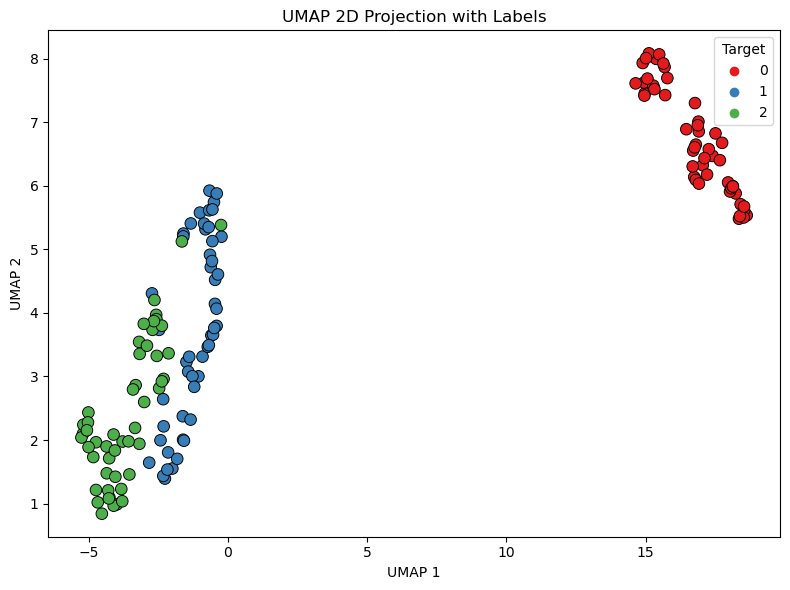

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

umap_2d["label"] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_2d, x="UMAP_1", y="UMAP_2", hue="label", palette="Set1", s=70, edgecolor="k")
plt.title("UMAP 2D Projection with Labels")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Target")
plt.tight_layout()
plt.show()


##### 📈 3D Scatter Plot (Optional)  
- **Visualizing clusters in 3D**: If `n_components=3`, plot the results in 3D.



/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


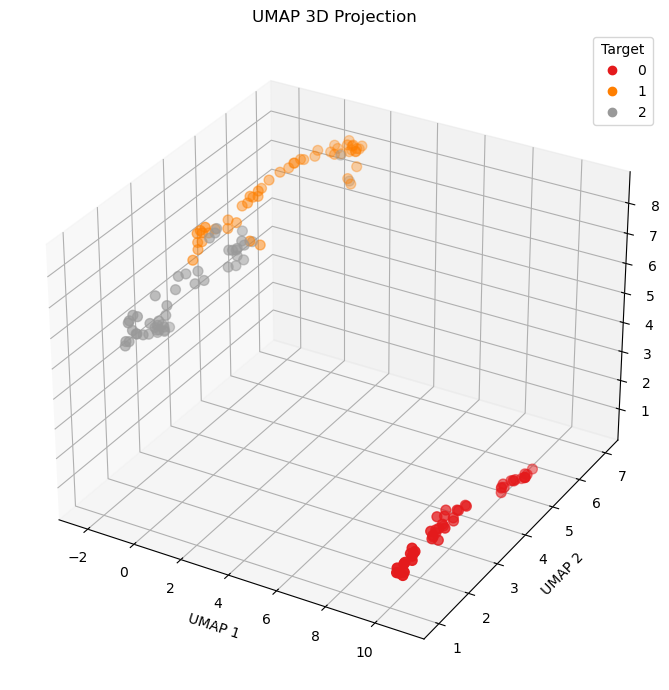

In [43]:
from mpl_toolkits.mplot3d import Axes3D

umap_3d = run_umap(X, n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
umap_3d["label"] = y

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(umap_3d["UMAP_1"], umap_3d["UMAP_2"], umap_3d["UMAP_3"],
                     c=umap_3d["label"], cmap="Set1", s=50)
ax.set_title("UMAP 3D Projection")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.legend(*scatter.legend_elements(), title="Target")
plt.tight_layout()
plt.show()


##### 🌐 KDE Density Plot  
- **Density visualization**: Show the density of data points in the UMAP-transformed space using Kernel Density Estimation.


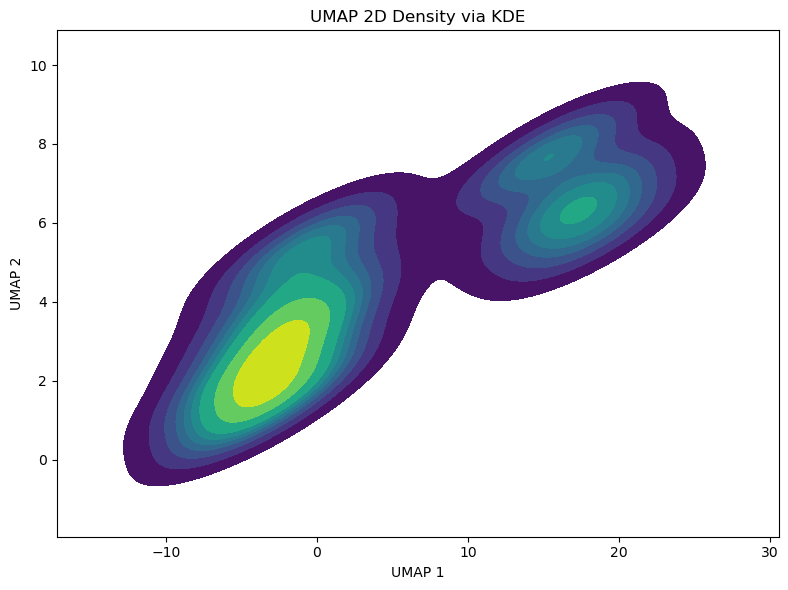

In [44]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=umap_2d, x="UMAP_1", y="UMAP_2", fill=True, cmap="viridis", thresh=0.05)
plt.title("UMAP 2D Density via KDE")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()


##### 🎨 Feature Coloring (Optional)  
- **Color points based on a feature**: Color points by a continuous or categorical feature to observe its influence on the UMAP projection.


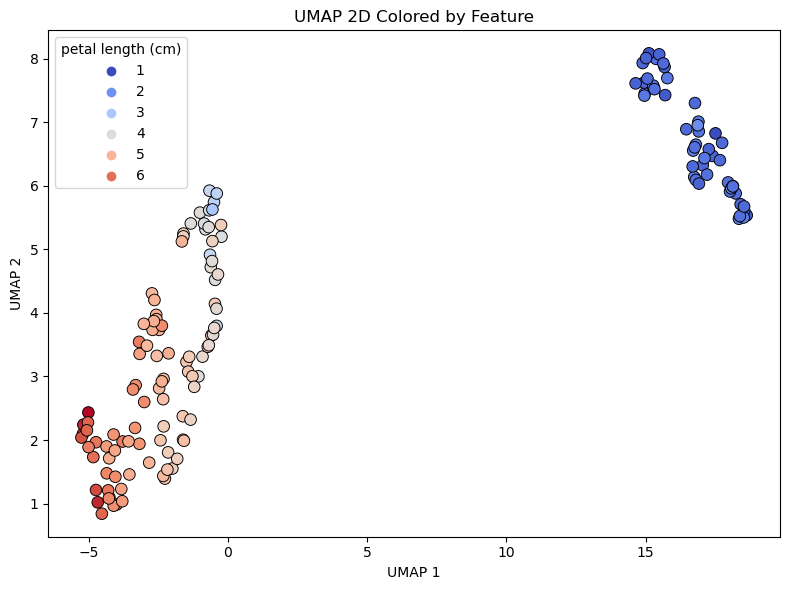

In [45]:
# Example: color by petal length
feature_col = X.iloc[:, 2]  # Iris petal length
umap_2d["feature"] = feature_col

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_2d, x="UMAP_1", y="UMAP_2", hue="feature", palette="coolwarm", s=70, edgecolor="k")
plt.title("UMAP 2D Colored by Feature")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title=iris.feature_names[2])
plt.tight_layout()
plt.show()


##### 🧠 UMAP with Clustering (Optional)  
- **Clustering with KMeans or DBSCAN**: Use UMAP-reduced data for clustering tasks and overlay cluster results.


/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


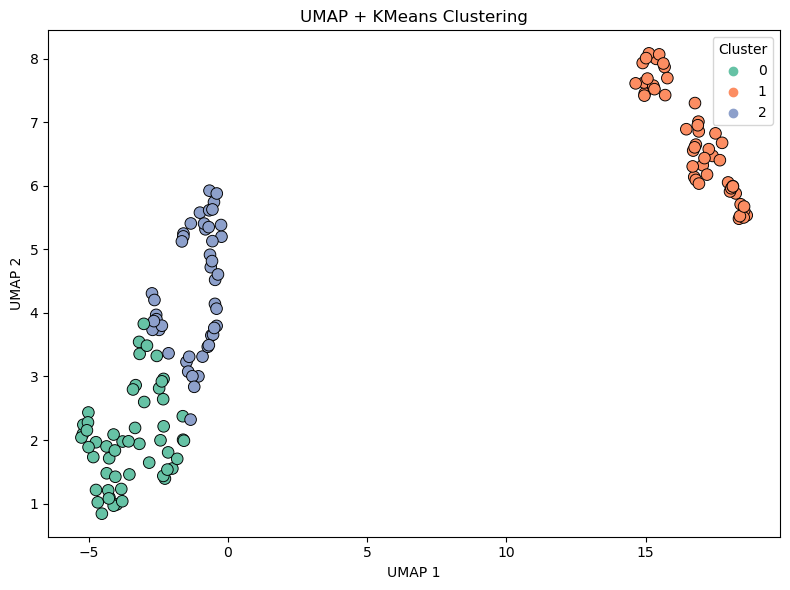

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
umap_2d["cluster"] = kmeans.fit_predict(umap_2d[["UMAP_1", "UMAP_2"]])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_2d, x="UMAP_1", y="UMAP_2", hue="cluster", palette="Set2", s=70, edgecolor="k")
plt.title("UMAP + KMeans Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


<a id="umap-transform-use"></a>
#### 🔁 Reusing UMAP for Feature Reduction  
- **Transform new data**: Once UMAP is trained, use `.transform()` to reduce new data points.  
- **Downstream tasks**: Use UMAP output for clustering or as features in machine learning models.

/Users/ashrithreddy/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


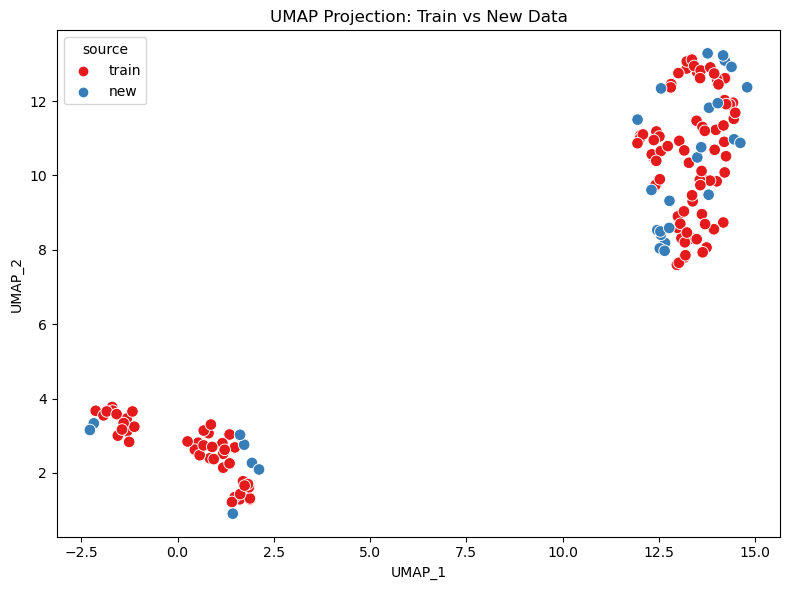

In [47]:
# Simulate new unseen data
X_train = X.sample(frac=0.8, random_state=42)
X_new = X.drop(X_train.index)

# Fit UMAP on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_new_scaled = scaler.transform(X_new)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_train_embed = umap_model.fit_transform(X_train_scaled)
X_new_embed = umap_model.transform(X_new_scaled)  # <- Reuse on new data

# Combine for downstream ML or clustering
X_combined = np.vstack([X_train_embed, X_new_embed])
X_combined_df = pd.DataFrame(X_combined, columns=["UMAP_1", "UMAP_2"])
X_combined_df["source"] = ["train"] * len(X_train) + ["new"] * len(X_new)

# Visualize train vs new points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_combined_df, x="UMAP_1", y="UMAP_2", hue="source", palette="Set1", s=70)
plt.title("UMAP Projection: Train vs New Data")
plt.tight_layout()
plt.show()


[Back to the top](#table-of-contents)
___



<a id="lda"></a>
# 📐 Linear Discriminant Analysis (LDA)



<a id="how-lda-works"></a>
#### 🔢 How LDA Works

<details><summary><strong>📖 Click to Expand</strong></summary>

##### 📐 What is LDA?

Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique that finds **linear combinations of features** that best separate two or more classes.

##### ⚙️ How It Works

- Maximizes the **distance between class means**
- Minimizes **variance within each class**
- Projects the data into a lower-dimensional space that **maximally preserves class separability**

##### 🎯 When to Use

- You have **labeled data** and want dimensionality reduction aligned with class boundaries
- Ideal as a preprocessing step for classification problems

</details>




<a id="lda-steps"></a>
#### 🧮 Step-by-Step Breakdown

<details><summary><strong>📖 Click to Expand</strong></summary>

1. **Compute class-wise means**: Calculate the mean vector for each class.

2. **Within-class scatter matrix** \( S_W \):  
   Measures variance within each class — the "tightness" of clusters.

3. **Between-class scatter matrix** \( S_B \):  
   Measures variance between the class means — the separation between class centers.

4. **Solve the generalized eigenvalue problem**:  
   \[
   S_W^{-1} S_B
   \]
   The eigenvectors form the new **discriminant axes**.

5. **Sort by eigenvalues**:  
   Select the top eigenvectors (directions) based on their eigenvalues — these are the most class-separating dimensions.

6. **Project the data**:  
   Multiply the original dataset by the top eigenvectors to reduce dimensions while maintaining class separability.

</details>




<a id="lda-impl"></a>
#### 🛠️ Implementation

<details><summary><strong>📖 Click to Expand</strong></summary>

##### 🧱 Why LDA Can’t Go Beyond (C - 1) Dimensions

The number of meaningful LDA components is bounded by:

\[
\min(n_{\text{features}},\ C - 1)
\]

Where:
- \( C \) = number of unique classes
- \( n_{\text{features}} \) = number of original features

This is because the between-class scatter matrix \( S_B \) has rank at most \( C - 1 \), limiting how many discriminant directions can exist.

##### 🔍 Implication

Even if your original data has 100 features, if you have only 3 classes, LDA can produce **at most 2 meaningful components**.

</details>



In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# Fit LDA (for 3 classes, max 2 components)
lda_model = LDA(n_components=2)
X_lda = lda_model.fit_transform(X_scaled, y)

<a id="lda-visuals"></a>
#### 📊 Visualizing LDA Output


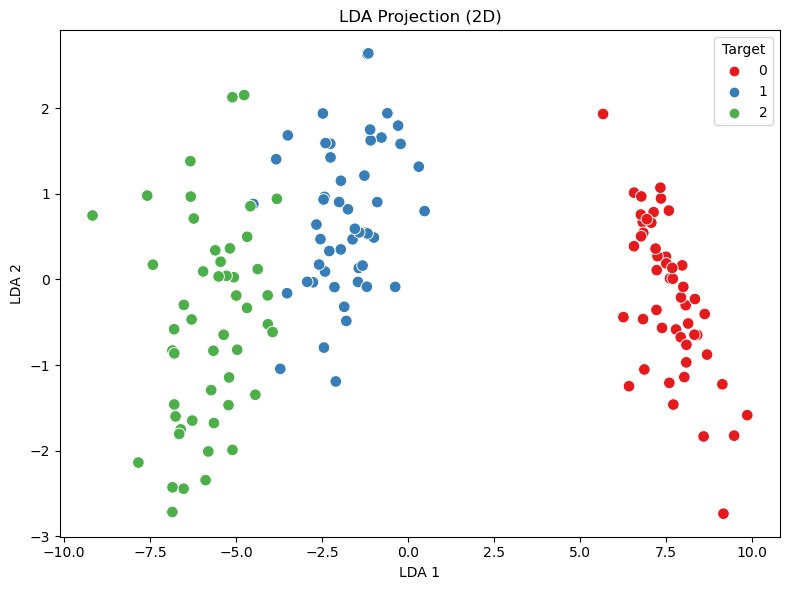

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine with labels for plotting
lda_df = pd.DataFrame(X_lda, columns=["LDA_1", "LDA_2"])
lda_df["label"] = y

# 2D scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=lda_df, x="LDA_1", y="LDA_2", hue="label", palette="Set1", s=70)
plt.title("LDA Projection (2D)")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.legend(title="Target")
plt.tight_layout()
plt.show()

[Back to the top](#table-of-contents)
___

<a id="cca"></a>
# 🔗 Canonical Correlation Analysis (CCA)

<a id="when-to-use-cca"></a>
#### 🧬 When It’s Useful

<details><summary><strong>📖 Click to Expand</strong></summary>

##### 🔗 Why Use CCA?

Canonical Correlation Analysis (CCA) is used to **find relationships between two sets of variables**.  
It’s especially useful when you have **two different views of the same observations**.

##### 📌 Typical Use Cases

- **Multimodal data**: Combining text and image features, or survey and behavioral signals.
- **Feature fusion**: Aligning representations from two separate systems.
- **Dimensionality reduction**: Extracting a shared latent space when PCA on each view independently isn’t enough.

##### 🧠 Practical Example

You have user demographic data and product interaction data. CCA finds **correlated dimensions** between the two — useful for recommendation, clustering, or cross-domain modeling.

</details>


<a id="cca-intuition"></a>
#### 🔄 Intuition: PCA for Two Views

<details><summary><strong>📖 Click to Expand</strong></summary>

##### 🧠 CCA vs PCA

- **PCA** finds directions of **maximum variance** within a single dataset.
- **CCA** finds directions in **two datasets** that are maximally **correlated**.

##### 🔍 Core Idea

Given two views of the same data (e.g., \( X \) and \( Y \)),  
CCA finds linear combinations \( a^T X \) and \( b^T Y \) such that:

\[
\text{corr}(a^T X, b^T Y)
\]

is maximized.

This reveals **latent structures shared** between both views — not just individual variation.

##### 🧭 Interpretation

- Each canonical component pair shows **how strongly aligned** both views are in that direction.
- If your first component has 0.9 correlation, you know the dominant pattern is **shared and interpretable**.

</details>

<a id="cca-dim-reduction"></a>
#### 📉 Dimensionality Reduction via Correlation

<details><summary><strong>📖 Click to Expand</strong></summary>

##### 📉 CCA as a Dimensionality Reduction Technique

CCA projects two datasets into a **shared latent space** where each pair of projected features is maximally correlated.  
The resulting components can be used just like PCA components — for visualization, modeling, or further analysis.

##### 📌 Key Characteristics

- **Supervised-like** projection: Takes into account two views, not just internal structure.
- **Bottleneck**: Extracts only the **common signals** — discards view-specific noise.
- **Output dimensionality**: Limited to the number of canonical directions with non-zero correlation  
  (i.e., up to \( \min(\text{n\_features\_X}, \text{n\_features\_Y}) \)).

##### ✅ When to use

- You want to **compress two datasets into a shared space**
- You’re looking to **fuse features** across systems for clustering, prediction, or visualization

</details>


<a id="cca-impl"></a>
#### 🛠️ Implementation

In [50]:
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Simulate two views from original data
np.random.seed(42)
n_samples = X.shape[0]

# View 1: Original iris features
X_view = X.values

# View 2: Linearly correlated view + noise
Y_view = X.values @ np.array([[0.5, 0.2, 0.1],
                              [0.3, 0.1, 0.4],
                              [0.2, 0.3, 0.1],
                              [0.1, 0.5, 0.3]]) + np.random.normal(0, 0.5, size=(n_samples, 3))

# Standardize both views
X_scaled = StandardScaler().fit_transform(X_view)
Y_scaled = StandardScaler().fit_transform(Y_view)

# Run CCA
cca = CCA(n_components=2)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)

# Store projections
cca_proj = pd.DataFrame(X_c, columns=["CCA_1", "CCA_2"])
cca_proj["label"] = y


<a id="cca-visuals"></a>
#### 📊 Visualizing CCA Output

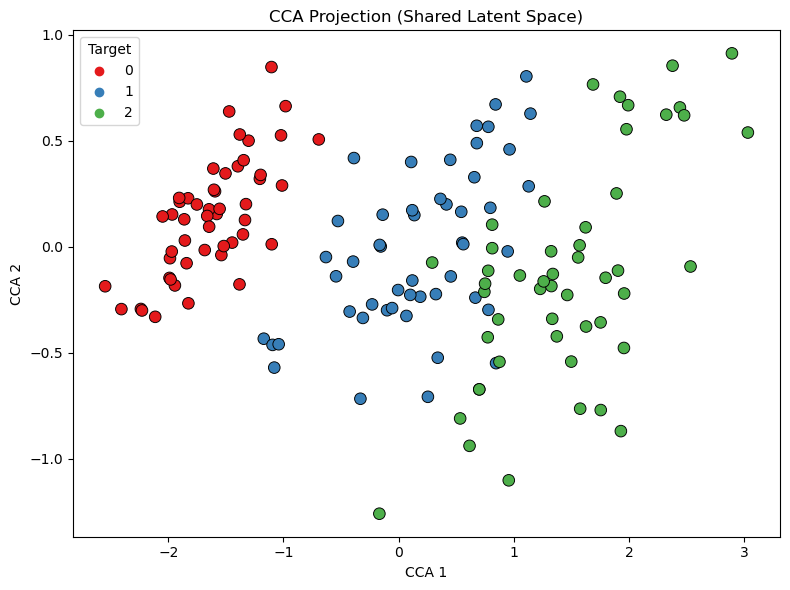

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cca_proj, x="CCA_1", y="CCA_2", hue="label", palette="Set1", s=70, edgecolor="k")
plt.title("CCA Projection (Shared Latent Space)")
plt.xlabel("CCA 1")
plt.ylabel("CCA 2")
plt.legend(title="Target")
plt.tight_layout()
plt.show()


[Back to the top](#table-of-contents)
___